In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import itertools
import math
import timeit
from decimal import Decimal

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.special as sp

In [4]:
from wolfram_grid import wolfram_dda, search_grid
from algorithms_stan import stan_grad_reg_inc_beta, stan_inc_beta, stan_inc_beta_strict
from algorithm_inbeder import inbeder
from plot import plot_zlevel, plot_time

In [5]:
algos = dict(
    stan_grad_reg_inc_beta = stan_grad_reg_inc_beta,
    stan_inc_beta = stan_inc_beta,
    stan_inc_beta_strict = stan_inc_beta_strict, 
    inbeder = inbeder,
)

# Accuracy comparison

In [6]:
a = 15
b = 1.25
z = 0.999

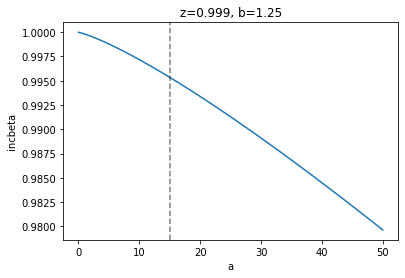

In [7]:
x = np.linspace(0, 50, 10000)
y = sp.betainc(x, b, z)
plt.plot(x, y)
plt.axvline(a, c='k', ls='dashed', alpha=.5)
plt.ylabel('incbeta')
plt.xlabel('a')
plt.title(f'{z=}, {b=}');

In [8]:
print(f'{"wolfram".rjust(25)}: {wolfram_dda(z, a, b)}')
for algo_name, algo in algos.items():
    print(f'{algo_name.rjust(25)}: {algo(z, a, b)[0]}')

                  wolfram: -0.0003813609775934895
   stan_grad_reg_inc_beta: -0.00038136097752478797
            stan_inc_beta: -0.00038136097696315
     stan_inc_beta_strict: -0.000381360977594094
                  inbeder: -0.0003813609775940947


In [9]:
def safe_division(xs, ys):
    result = []
    for x, y in zip(xs, ys):
        if y != 0:
            result.append(x / y)
        else:
            result.append(np.nan)
    return np.array(result)

def safe_log(xs):
    result = []
    for x in xs:
        if x != 0:
            result.append(math.log(x))
        else:
            result.append(np.NINF)
            
    return np.array(result)

In [10]:
df = pd.DataFrame(
    columns = ('z', 'a', 'b', 'wolfram', *algos.keys())
)

for z, a, b in itertools.product(search_grid['z'], search_grid['a'], search_grid['b']):
    w_dda = Decimal(wolfram_dda(z, a, b))
    algos_dda = [Decimal(algo(z, a, b)[0]) for algo in algos.values()]
    df.loc[len(df)] = [z, a, b, w_dda, *algos_dda]

for algo_name in algos.keys():
    df[f'{algo_name}_abserr'] = np.abs(df['wolfram'] - df[algo_name])
for algo_name in algos.keys():
    df[f'{algo_name}_relerr'] = np.abs(1 - safe_division(df[algo_name], df['wolfram']))
for algo_name in algos.keys():
    df[f'{algo_name}_abserr_log'] = safe_log(df[f'{algo_name}_abserr'])
for algo_name in algos.keys():
    df[f'{algo_name}_relerr_log'] = safe_log(df[f'{algo_name}_relerr'])
    
# df.to_csv('dda.csv')

/home/ricardo/Documents/Projects/incbeta_test/algorithms_stan.py:91: RuntimeWarning: invalid value encountered in double_scalars
  g1 = (dBda - b1 * (digammaA - digammaSum)) / betaAB
/home/ricardo/Documents/Projects/incbeta_test/algorithms_stan.py:92: RuntimeWarning: invalid value encountered in double_scalars
  g2 = (dBdb - b1 * (digammaB - digammaSum)) / betaAB


In [11]:
# df = pd.read_csv('dda.csv', index_col=0)
# df['z'] = df['z'].round(3)

In [12]:
df

,z,a,b,wolfram,stan_grad_reg_inc_beta,stan_inc_beta,stan_inc_beta_strict,inbeder,stan_grad_reg_inc_beta_abserr,stan_inc_beta_abserr,...,stan_inc_beta_strict_relerr,inbeder_relerr,stan_grad_reg_inc_beta_abserr_log,stan_inc_beta_abserr_log,stan_inc_beta_strict_abserr_log,inbeder_abserr_log,stan_grad_reg_inc_beta_relerr_log,stan_inc_beta_relerr_log,stan_inc_beta_strict_relerr_log,inbeder_relerr_log
0,0.001,1.5,1.25,-0.0002866563657042640054020687934155375842237...,-0.0002866563657042636801414170477642073819879...,-0.0002866563657042595601731616028473581536673...,-0.0002866563657042636801414170477642073819879...,-0.0002866563657042642764526119147916460860869...,3.252606517456513302022358403E-19,4.445228907190568179430556484E-18,...,1.1346709533087E-15,9.45559127757E-16,-42.569660,-39.954700,-42.569660,-42.751982,-34.412434,-31.797474,-34.412434,-34.594755
1,0.001,1.5,12.50,-0.0053857750078742730459602228165749693289399...,-0.0053857750078742799848541267238033469766378...,-0.0053857750076399492009104896794724481878802...,-0.0053857750078742799848541267238033469766378...,-0.0053857750078742877911097686194352718302980...,6.938893903907228377647697926E-18,2.343238450497331371025211411E-13,...,1.288374262527E-15,2.737795307870E-15,-39.509389,-29.082072,-39.509389,-38.755617,-34.285395,-23.858078,-34.285395,-33.531623
2,0.001,1.5,125.00,-0.0865505603779457982627221213078883010894060...,-0.0865505603779555959809144383143575396388769...,-0.0865505216245416597597994723400915972888469...,-0.0865505603779512661111184002038498874753713...,-0.0865505603779557347587925164589250925928354...,9.797718192317006469238549471E-15,3.875340413850292264896779670E-8,...,6.3175193463822E-14,1.14805681523087E-13,-32.256627,-17.066047,-32.839891,-32.242562,-29.809600,-14.619021,-30.392865,-29.795535
3,0.001,1.5,1250.00,-0.3670055021667202876933799871039809659123420...,-0.3670055021665504790817635694111231714487075...,-0.3631770814579012851552874963090289384126663...,-0.3670055021210104628792691983107943087816238...,-0.3670055021665507011263684944424312561750411...,1.698086116164176928577944636E-13,0.003828420708819002538092490795,...,1.245480641141616992E-10,4.620818107910934E-13,-29.404104,-5.565303,-23.808708,-29.405413,-28.401726,-4.562924,-22.806329,-28.403034
4,0.001,1.5,12500.00,-0.0000393756276793055803864262998104095458984375,-0.0000393756212460058934170421818254936852099...,1.82262403377648296576296615967294201254844665...,-0.0000393756281077282992370350300781467467459...,-0.0000393756371992461684538623656326450372944...,6.433299686969384117984915861E-12,1.822663409404162271343352586,...,1.0880403541497634759E-8,2.41772414794311351856E-7,-25.769534,0.600299,-28.478666,-25.377633,-15.627170,10.742662,-18.336303,-15.235269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,0.999,15000.0,1.25,-6.1422760376990657589152725580328162635623812...,-6.5954322570608909834294579968669465508401827...,0.00091716708044415728561665757112564278941135...,-6.5953776013738035716416612262756949403019746...,-6.5954322570614482963671655992628911624464649...,4.531562193618252245141854388E-11,0.0009171676946717610555232334627,...,0.073767697982598716761766836,0.073776596261886275300246955,-23.817369,-6.994220,-23.817490,-23.817369,-2.606714,14.216435,-2.606834,-2.606714
121,0.999,15000.0,12.50,-0.0000373993100414921801968870518351195642026...,-0.0000746930863225586368168290585245472357200...,-0.0000599781046185932353040706765945344614010...,-0.0000746930861981087750511507095119156929285...,-0.0000746930863231799795293533450468714818271...,0.00003729377628106645661994200669,0.00002257879457710105510718362476,...,0.997178186315242122361792812,0.997178189659453669030541712,-10.196684,-10.698499,-10.196684,-10.196684,-0.002826,-0.504641,-0.002826,-0.002826
122,0.999,15000.0,125.00,0.00729857796930133417845354415476322174072265625,0.00723191092067584744007557873146652127616107...,-2.3012781175009738888685601467502847715930677...,-2.301280

In [13]:
for z in search_grid['z']:
    lnvalues = df.loc[df['z']==z, 'stan_grad_reg_inc_beta_abserr_log':'inbeder_abserr_log'].values
    flnvalues = lnvalues[np.isfinite(lnvalues)]
    print(z, np.min(flnvalues), np.max(flnvalues))

0.001 -569.1887737193952 0.6002988431057652
0.25 -555.6153390412865 497.253901682031
0.5 -697.9880283364658 40.68988186507227
0.75 -437.25522530173436 165.924433261865
0.999 -35.941949452948876 86.36885524378881


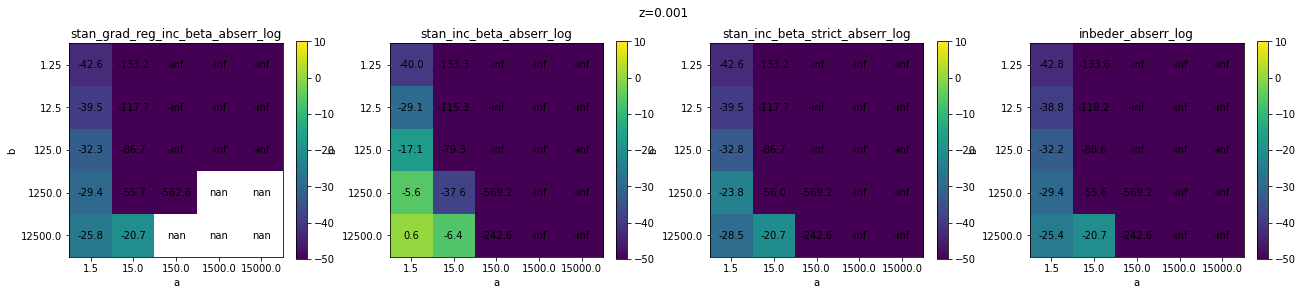

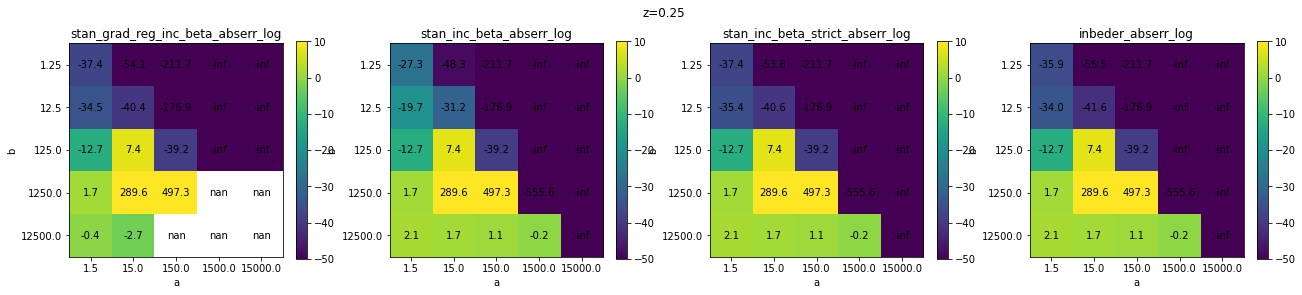

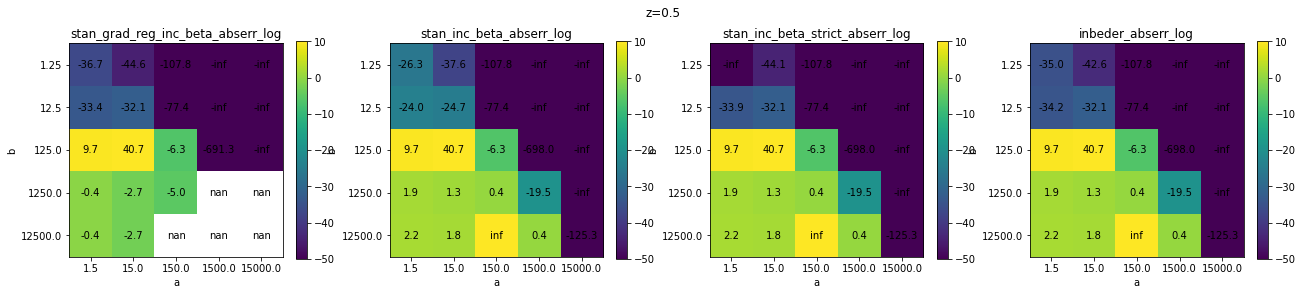

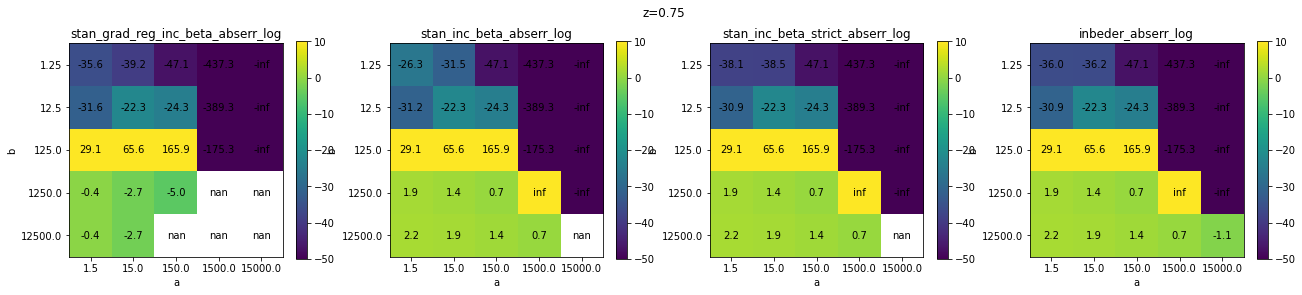

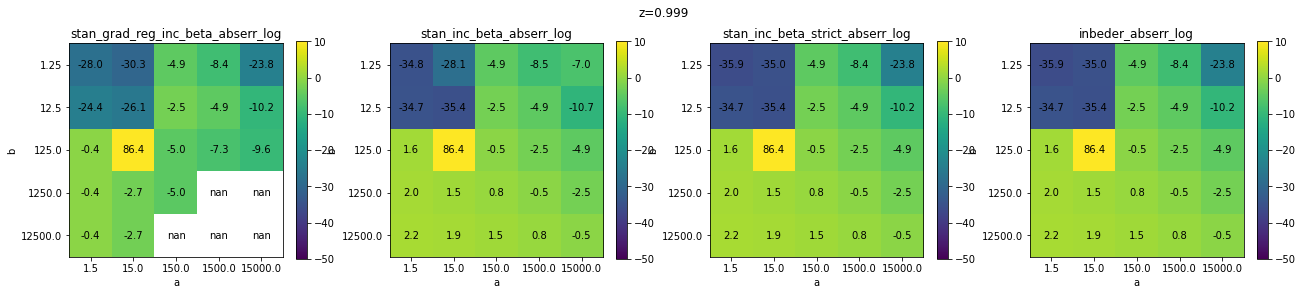

In [14]:
for z in search_grid['z']:
    tdf = df[df['z']==z][[
        'z', 'a', 'b', 
        'stan_grad_reg_inc_beta_abserr_log', 
        'stan_inc_beta_abserr_log',
        'stan_inc_beta_strict_abserr_log',
        'inbeder_abserr_log',
    ]]
    plot_zlevel(tdf, vmin=-50, vmax=10)

In [15]:
for z in search_grid['z']:
    lnvalues = df.loc[df['z']==z, 'stan_grad_reg_inc_beta_relerr_log':'inbeder_relerr_log'].values
    flnvalues = lnvalues[np.isfinite(lnvalues)]
    print(z, np.min(flnvalues), np.max(flnvalues))

0.001 -34.59475525178239 10.74266236298957
0.25 -35.8466474260538 4.1611809467066166e-09
0.5 -35.39121404415079 0.0
0.75 -36.3283117141032 0.0
0.999 -27.532017138004445 14.216435337006567


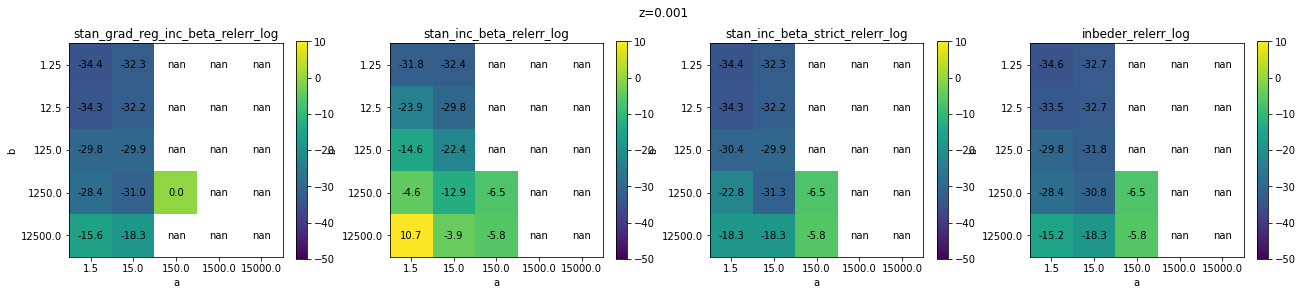

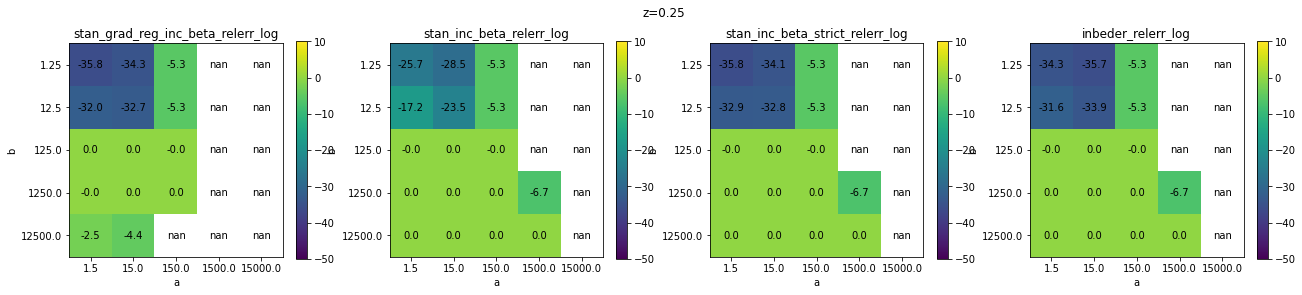

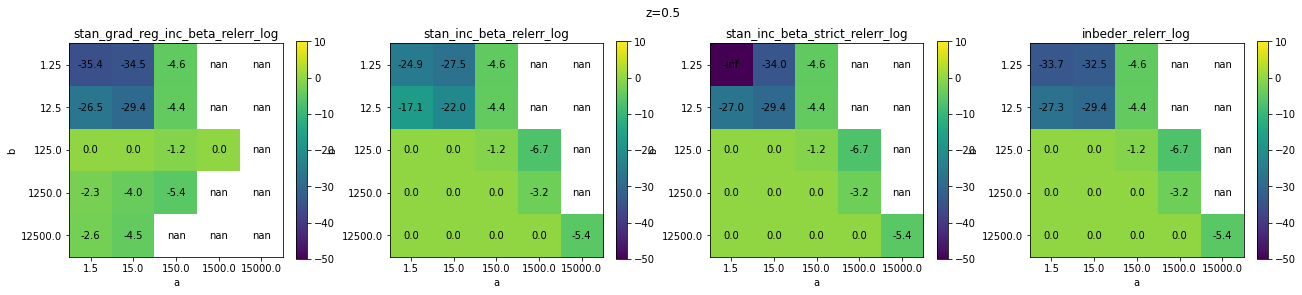

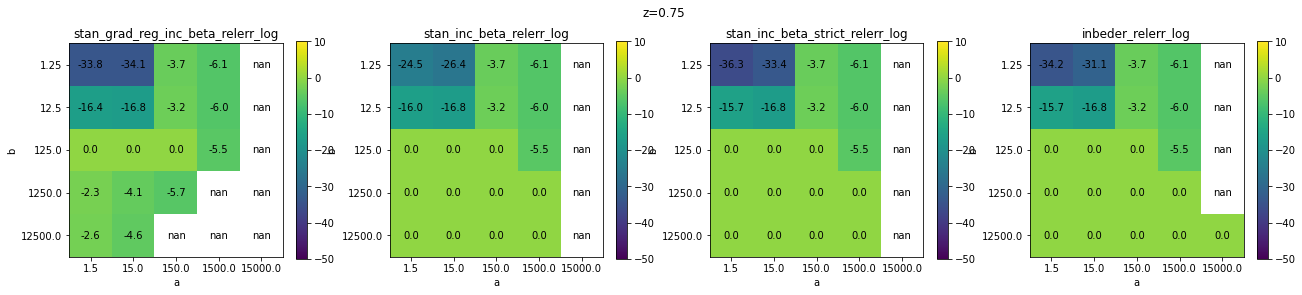

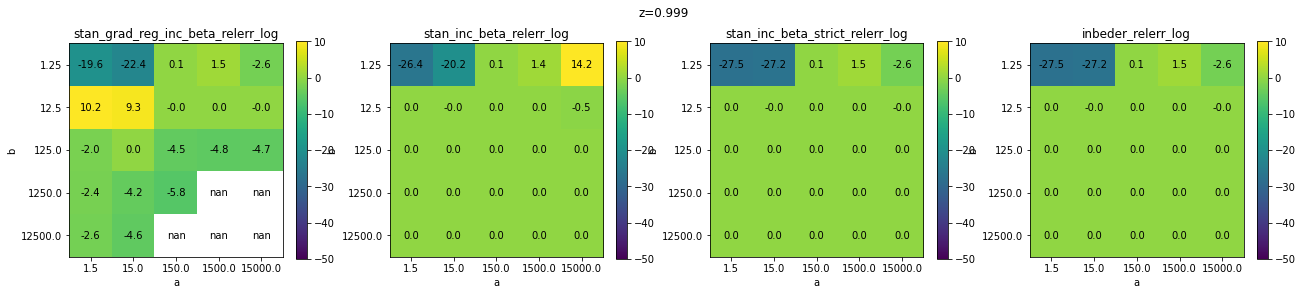

In [16]:
for z in search_grid['z']:
    tdf = df[df['z']==z][[
        'z', 'a', 'b', 
        'stan_grad_reg_inc_beta_relerr_log', 
        'stan_inc_beta_relerr_log',
        'stan_inc_beta_strict_relerr_log',
        'inbeder_relerr_log',
    ]]
    plot_zlevel(tdf, vmin=-50, vmax=10)

# Speed comparison

In [17]:
tdf = pd.DataFrame(
    columns = ('z', 'a', 'b', *algos.keys())
)

for i, (z, a, b) in enumerate(itertools.product(search_grid['z'], search_grid['a'], search_grid['b'])):
    if i % 5 == 0:
        print(i)

    algos_avg_time = []
    for j, algo in enumerate(algos.values()):
        algo_avg_time = timeit.timeit(lambda: algo(z, a, b), number=100) / 100
        algos_avg_time.append(algo_avg_time)
    
    tdf.loc[len(tdf)] = [z, a, b, *algos_avg_time]

for algo_name in algos.keys():
    tdf[f'{algo_name}_log'] = np.log(tdf[algo_name])

# tdf.to_csv('time.csv')

0
5
10
15
20


/home/ricardo/Documents/Projects/incbeta_test/algorithms_stan.py:91: RuntimeWarning: invalid value encountered in double_scalars
  g1 = (dBda - b1 * (digammaA - digammaSum)) / betaAB
/home/ricardo/Documents/Projects/incbeta_test/algorithms_stan.py:92: RuntimeWarning: invalid value encountered in double_scalars
  g2 = (dBdb - b1 * (digammaB - digammaSum)) / betaAB


25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120


In [18]:
# tdf = pd.read_csv('time.csv', index_col=0)
# tdf['z'] = tdf['z'].round(3)

In [19]:
tdf

,z,a,b,stan_grad_reg_inc_beta,stan_inc_beta,stan_inc_beta_strict,inbeder,stan_grad_reg_inc_beta_log,stan_inc_beta_log,stan_inc_beta_strict_log,inbeder_log
0,0.001,1.5,1.25,0.000135,0.000023,0.000031,0.000060,-8.910014,-10.667713,-10.385859,-9.713750
1,0.001,1.5,12.50,0.000167,0.000023,0.000031,0.000060,-8.697839,-10.677411,-10.392898,-9.725603
2,0.001,1.5,125.00,0.000225,0.000025,0.000034,0.000074,-8.400855,-10.595256,-10.278048,-9.505001
3,0.001,1.5,1250.00,0.000399,0.000025,0.000048,0.000122,-7.826702,-10.581425,-9.951435,-9.014557
4,0.001,1.5,12500.00,0.001057,0.000018,0.000121,0.000155,-6.852547,-10.928733,-9.018509,-8.773283
...,...,...,...,...,...,...,...,...,...,...,...
120,0.999,15000.0,1.25,0.648253,0.000019,0.000137,0.000142,-0.433474,-10.865635,-8.896388,-8.859987
121,0.999,15000.0,12.50,0.953471,0.000043,0.000096,0.000231,-0.047646,-10.058176,-9.254965,-8.371827
122,0.999,15000.0,125.00,0.000025,0.000030,0.000048,0.000053,-10.593146,-10.426974,-9.943834,-9.841316
123,0.999,15000.0,1250.00,0.000026,0.000027,0.000036,0.000057,-10.545163,-10.510721,-10.224254,-9.775621


In [20]:
for z in search_grid['z']:
    lnvalues = tdf.loc[tdf['z']==z, 'stan_grad_reg_inc_beta_log':'inbeder_log'].values
    print(z, np.min(lnvalues), np.max(lnvalues))

0.001 -10.928733029307892 -6.852547135144596
0.25 -10.784762553788648 -4.328692820721733
0.5 -10.771716004375417 -5.106534788364815
0.75 -10.706441564000892 -1.3331727668855229
0.999 -10.865634805070519 0.2827554551250597


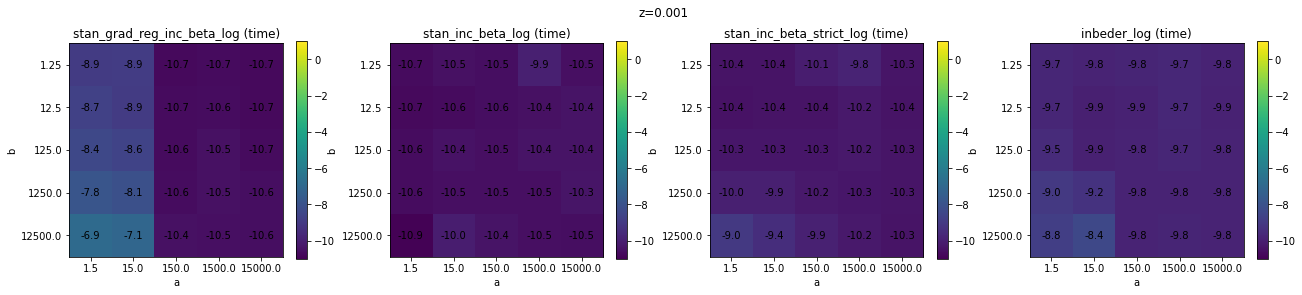

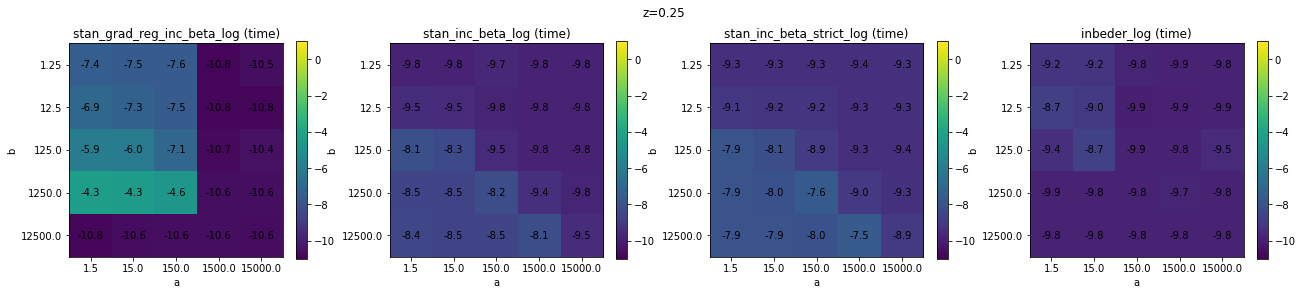

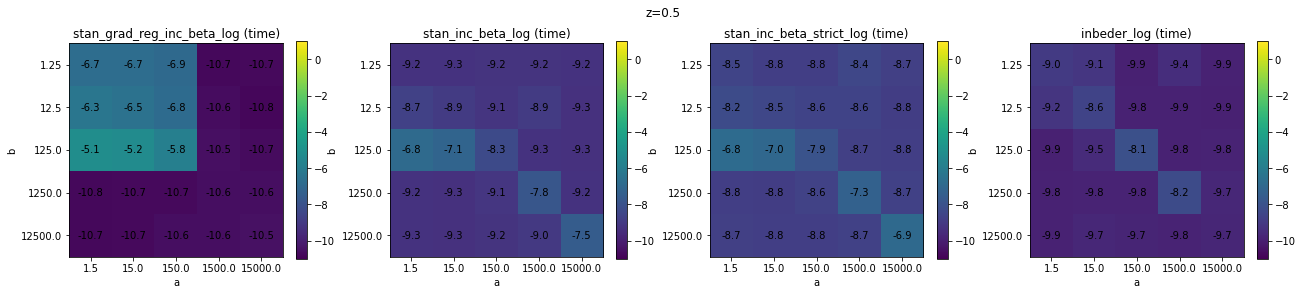

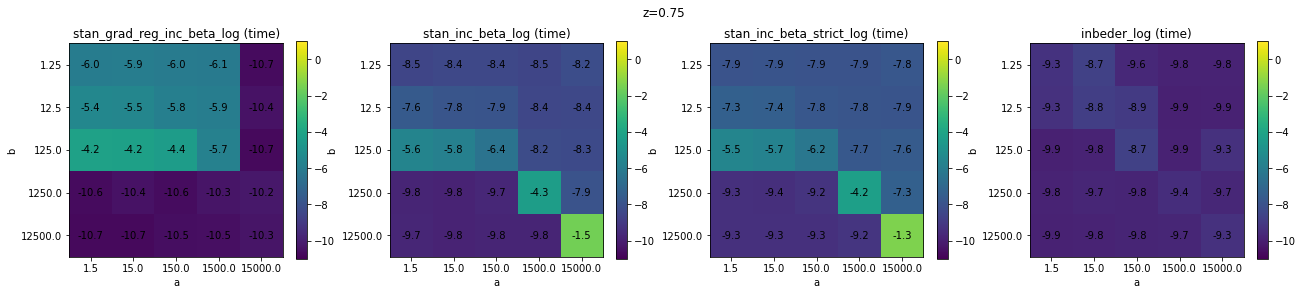

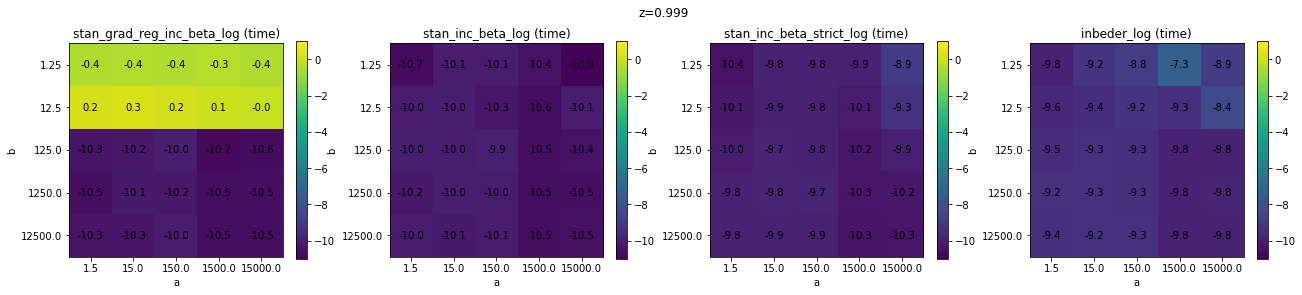

In [21]:
for z in search_grid['z']:
    ttdf = tdf[tdf['z']==z][[
        'z', 'a', 'b', 
        'stan_grad_reg_inc_beta_log', 
        'stan_inc_beta_log',
        'stan_inc_beta_strict_log',
        'inbeder_log',
    ]]
    plot_time(ttdf, -11, 1)

## Cases where wolfram and stan_grad_reg_inc_beta diverge from rest

### Wolfram derivative is way off

In [22]:
z = 0.25
a = 150
b = 1250

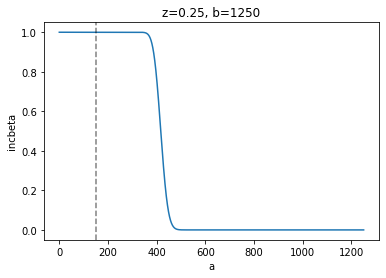

In [23]:
x = np.linspace(0, max(a, b), 10000)
y = sp.betainc(x, b, z)
plt.plot(x, y)
plt.axvline(a, c='k', ls='dashed', alpha=.5)
plt.ylabel('incbeta')
plt.xlabel('a')
plt.title(f'{z=}, {b=}');

In [24]:
print(f'{"wolfram".rjust(25)}: {wolfram_dda(z, a, b)}')
for algo_name, algo in algos.items():
    print(f'{algo_name.rjust(25)}: {algo(z, a, b)[0]}')

                  wolfram: -9.0079425013435e+215
   stan_grad_reg_inc_beta: 5.64240006350661e-13
            stan_inc_beta: -6.875931379629293e-42
     stan_inc_beta_strict: -6.8759313797203e-42
                  inbeder: -6.875906440587697e-42


### Wolfram and stan_grad_reg_inc_beta agree, but it looks like derivative should be 0

In [25]:
z = 0.25
a = 15
b = 12500

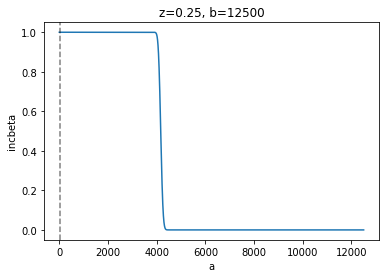

In [26]:
x = np.linspace(0, max(a, b), 10000)
y = sp.betainc(x, b, z)
plt.plot(x, y)
plt.axvline(a, c='k', ls='dashed', alpha=.5)

plt.ylabel('incbeta')
plt.xlabel('a')
plt.title(f'{z=}, {b=}');

In [27]:
print(f'{"wolfram".rjust(25)}: {wolfram_dda(z, a, b)}')
for algo_name, algo in algos.items():
    print(f'{algo_name.rjust(25)}: {algo(z, a, b)[0]}')

                  wolfram: 5.374002228495603
   stan_grad_reg_inc_beta: 5.307335561828936
            stan_inc_beta: -0.0
     stan_inc_beta_strict: -0.0
                  inbeder: -0.0


### All fail to converge, except inbeder which returns 0

In [28]:
z = 0.75
a = 15000
b = 12500

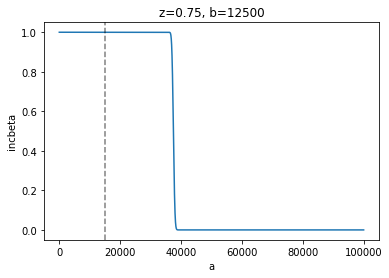

In [29]:
x = np.linspace(0, b * 8, 10000)
y = sp.betainc(x, b, z)
plt.plot(x, y)
plt.axvline(a, c='k', ls='dashed', alpha=.5)

plt.ylabel('incbeta')
plt.xlabel('a')
plt.title(f'{z=}, {b=}');

In [30]:
print(f'{"wolfram".rjust(25)}: {wolfram_dda(z, a, b)}')
for algo_name, algo in algos.items():
    print(f'{algo_name.rjust(25)}: {algo(z, a, b)[0]}')

                  wolfram: 0.3184688828938622
   stan_grad_reg_inc_beta: nan
            stan_inc_beta: nan


/home/ricardo/Documents/Projects/incbeta_test/algorithms_stan.py:91: RuntimeWarning: invalid value encountered in double_scalars
  g1 = (dBda - b1 * (digammaA - digammaSum)) / betaAB
/home/ricardo/Documents/Projects/incbeta_test/algorithms_stan.py:92: RuntimeWarning: invalid value encountered in double_scalars
  g2 = (dBdb - b1 * (digammaB - digammaSum)) / betaAB


     stan_inc_beta_strict: nan
                  inbeder: -0.0
